Example tutorial on a multilabel text classification to predict the subject areas of arXiv papers from abstract bodies.

In [4]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Load Dataset

In [9]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
print(f"Number of rows in dataset: {len(arxiv_data)}")
arxiv_data.head()

Number of rows in dataset: 51774


,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [14]:
# Remove row duplicates
print(f"Number of rows in dataset before removing duplicates: {len(arxiv_data)}")
arxiv_data = arxiv_data[~arxiv_data.titles.duplicated()]
print(f"Number of rows in dataset after removing duplicates: {len(arxiv_data)}")

# Get number of terms with lowest occurence
print(sum(arxiv_data.terms.value_counts() == 1))
# Get the number of unique terms
print(len(arxiv_data.terms.unique()))

# Filter the rare terms
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

Number of rows in dataset before removing duplicates: 38972
Number of rows in dataset after removing duplicates: 38972
2321
3157


(36651, 3)

In [15]:
# Convert the string labels to list of strings
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [20]:
# Use stratified splits to help with class imbalance
test_split = 0.1

# train test split
train_df, test_df = train_test_split(arxiv_data_filtered,
                                     test_size=test_split,
                                     stratify=arxiv_data_filtered["terms"].values,)

# Split the test into validation and new test sets
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [23]:
# Multi-label binarization
terms= tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print("Vocabulary: \n")
print(vocab)

Vocabulary: 

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.SE', 'cs.NI', 'stat.CO', 'I.2.6', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', 'math.DS', '68T05', 'quant-ph', 'cs.CC', 'I.4.6', 'physics.data-an', 'physics.soc-ph', 'physics.ao-ph', 'cs.DM', 'q-bio.GN', 'econ.EM', 'physics.med-ph', 'cs.PF', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.FL', 'I.4', 'q-fin.TR', 'I.5.4', 'I.2', '68U10', 'physics.geo-ph', 'hep-ex', '68T10', 'physics.optics', 'cond-mat.mtrl-sci', 'q-fin.CP', 'physics.flu-dyn', 'math.CO', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.

In [31]:
sample_label = train_df["terms"].iloc[50]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")
print(f"Label dimension: {label_binarized.shape}")

Original label: ['cs.LG', 'cs.CV']
Label-binarized representation: [[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]]
Label dimension: (1, 153)


Data Preprocessing

In [33]:
# Get data statistics
train_df.summaries.apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.480703
std         41.476307
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

In [37]:
# Set model parameters
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def prepare_dataset(df, is_train=False):
    labels = tf.ragged.constant(df["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (df["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size*10) if is_train else dataset
    return dataset.batch(batch_size)

train_dataset = prepare_dataset(train_df, is_train=True)
validation_dataset = prepare_dataset(val_df)
test_dataset = prepare_dataset(test_df)

print(f"Number of batches in train set: {len(train_dataset)}")
print(f"Number of batches in validation set: {len(validation_dataset)}")
print(f"Number of batches in test set: {len(test_dataset)}")

Number of batches in train set: 258
Number of batches in validation set: 15
Number of batches in test set: 15


In [41]:
# Preview sample dataset
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(F"Label: {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Neural autoregressive sequence models are used to generate sequences in a\nvariety of natural language processing (NLP) tasks, where they are evaluated\naccording to sequence-level task losses. These models are typically trained\nwith maximum likelihood estimation, which ignores the task loss, yet\nempirically performs well as a surrogate objective. Typical approaches to\ndirectly optimizing the task loss such as policy gradient and minimum risk\ntraining are based around sampling in the sequence space to obtain candidate\nupdate directions that are scored based on the loss of a single sequence. In\nthis paper, we develop an alternative method based on random search in the\nparameter space that leverages access to the maximum likelihood gradient. We\npropose maximum likelihood guided parameter search (MGS), which samples from a\ndistribution over update directions that is a mixture of random search around\nthe current parameters and around the maximum likelihood gradient, w

In [45]:
# Vectorization layer
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(f"Vocabulary size: {vocabulary_size}")

text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

Vocabulary size: 153031


Build and Train Model

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 162s 617ms/step - binary_accuracy: 0.9718 - loss: 0.0694 - val_binary_accuracy: 0.9938 - val_loss: 0.0195
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 162s 627ms/step - binary_accuracy: 0.9985 - loss: 0.0051 - val_binary_accuracy: 0.9938 - val_loss: 0.0270
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 162s 627ms/step - binary_accuracy: 0.9998 - loss: 0.0011 - val_binary_accuracy: 0.9936 - val_loss: 0.0340
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 162s 628ms/step - binary_accuracy: 0.9999 - loss: 4.4254e-04 - val_binary_accuracy: 0.9937 - val_loss: 0.0395
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 163s 629ms/step - binary_accuracy: 1.0000 - loss: 2.5287e-04 - val_binary_accuracy: 0.9937 - val_loss: 0.0427
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 163s 629ms/step - binary_accuracy: 1.0000 - loss: 1.5215e-04 - val_binary_accuracy: 0.9938 - val_loss: 0.0453
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 158s 610ms/step - binary_accuracy: 1.0000 - loss: 1.2636e-04 - val_binar

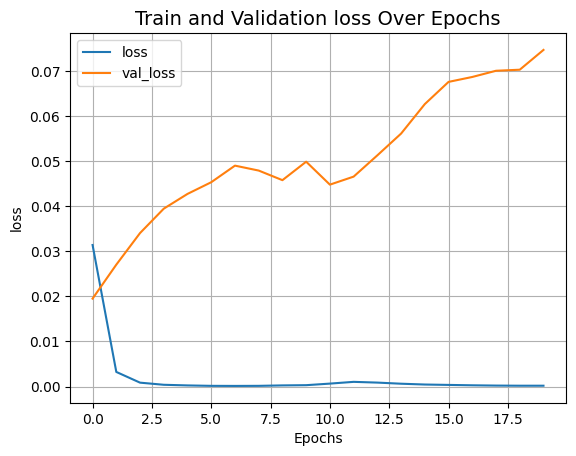

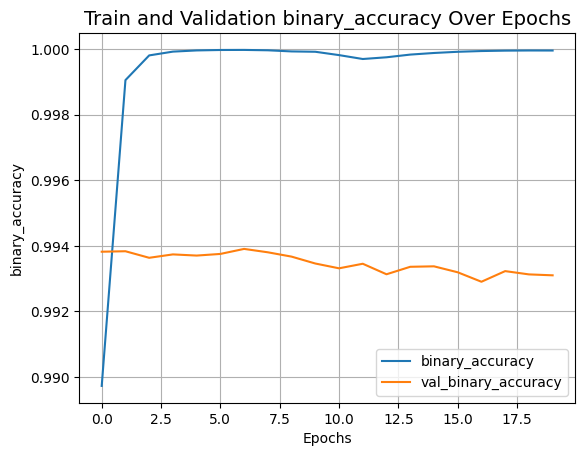

In [46]:
model = keras.Sequential(
    [
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
    ]
)

epochs=20
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [49]:
# Evaluate model
_, binary_acc = model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc*100, 2)}%.")

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - binary_accuracy: 0.9932 - loss: 0.0697
Categorical accuracy on the test set: 99.33%.


In [61]:
# Export model for inference on raw text data
model_for_export = keras.Sequential([
    text_vectorizer, model
])

# Create dataset to text
inference_dataset = prepare_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_export.predict(text_batch)

# Inference
for i, text in enumerate(text_batch[:2]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Labels: {invert_multi_hot(label[0])}")
    predicted_proba = [prob for prob in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse = True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Abstract: b'This paper investigates an important problem in stream mining, i.e.,\nclassification under streaming emerging new classes or SENC. The common\napproach is to treat it as a classification problem and solve it using either a\nsupervised learner or a semi-supervised learner. We propose an alternative\napproach by using unsupervised learning as the basis to solve this problem. The\nSENC problem can be decomposed into three sub problems: detecting emerging new\nclasses, classifying for known classes, and updating models to enable\nclassification of instances of the new class and detection of more emerging new\nclasses. The proposed method employs completely random trees which have been\nshown to work well in unsupervised learning and supervised learning\nindependently in the literature. This is the first time, as far as we know,\nthat completely random trees are used as a single common core to solve all\nthree sub problems: unsupervised lear